## Реализовать метод Верле для системы 3 тел и продемонстрировать его стабильность (сохранение полной энергии системы со временем)

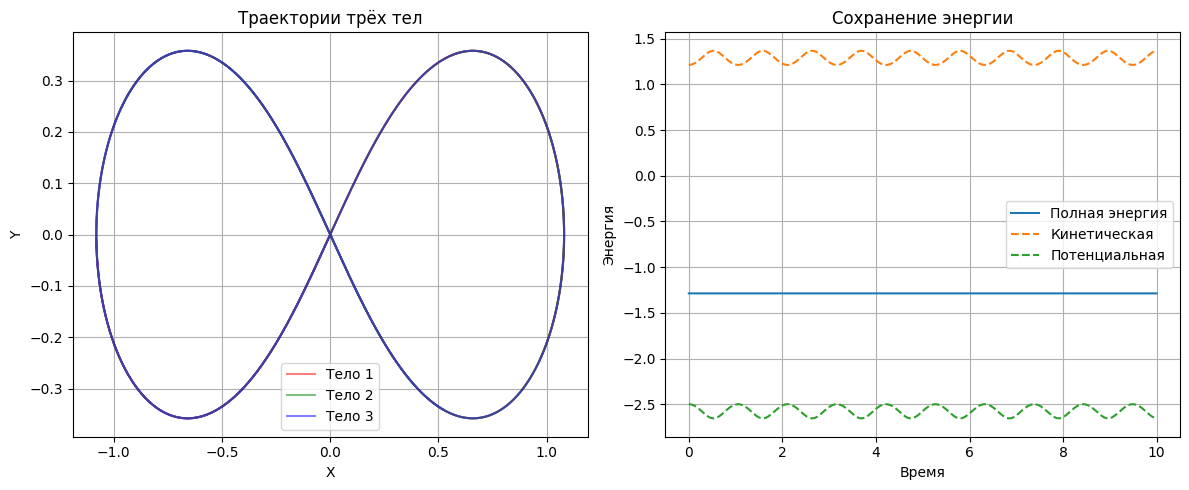

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def verlet_method(f, r0, v0, t_max, dt, masses, G):
    """Реализация метода Верле для системы тел"""
    t_list = np.arange(0, t_max, dt)
    n_steps = len(t_list)
    n_bodies = r0.shape[0]

    r_list = np.zeros((n_steps, n_bodies, 2))
    v_list = np.zeros((n_steps, n_bodies, 2))

    r_list[0] = r0
    v_list[0] = v0

    # Начальное ускорение
    a0 = f(r_list[0], masses, G)

    # Первый шаг
    r_list[1] = r_list[0] + v_list[0] * dt + 0.5 * a0 * dt**2

    # Основной цикл
    for i in range(1, n_steps - 1):
        a_current = f(r_list[i], masses, G)
        r_list[i + 1] = 2 * r_list[i] - r_list[i - 1] + a_current * dt**2

    # Вычисление скоростей
    for i in range(1, n_steps):
        if i < n_steps - 1:
            v_list[i] = (r_list[i + 1] - r_list[i - 1]) / (2 * dt)
        else:
            v_list[i] = (r_list[i] - r_list[i - 1]) / dt

    return t_list, r_list, v_list


def compute_accelerations(positions, masses, G):
    """Вычисление ускорений для всех тел"""
    n_bodies = len(masses)
    accelerations = np.zeros_like(positions)

    for i in range(n_bodies):
        for j in range(n_bodies):
            if i != j:
                dr = positions[j] - positions[i]
                r_norm = np.linalg.norm(dr) + 1e-10  # Для избежания деления на ноль
                accelerations[i] += G * masses[j] * dr / r_norm**3
    return accelerations


def compute_energy(positions, velocities, masses, G):
    """Вычисление полной энергии системы"""
    kinetic = 0.0
    potential = 0.0
    n_bodies = len(masses)

    for i in range(n_bodies):
        kinetic += 0.5 * masses[i] * np.sum(velocities[i] ** 2)
        for j in range(i + 1, n_bodies):
            dr = positions[j] - positions[i]
            r_norm = np.linalg.norm(dr)
            potential -= G * masses[i] * masses[j] / r_norm

    return kinetic + potential, kinetic, potential


# Параметры системы
G = 1.0
masses = np.array([1.0, 1.0, 1.0])

# Начальные условия (пример стабильной конфигурации из инета)
r0 = np.array(
    [
        [0.97000436, -0.24308753],  # Тело 1
        [-0.97000436, 0.24308753],  # Тело 2
        [0.0, 0.0],  # Тело 3
    ]
)

v0 = np.array(
    [
        [0.466203685, 0.43236573],  # Тело 1
        [0.466203685, 0.43236573],  # Тело 2
        [-2 * 0.466203685, -2 * 0.43236573],  # Тело 3
    ]
)

# Параметры интегрирования
t_max = 10.0
dt = 0.001

# Интегрирование
t_list, r_list, v_list = verlet_method(
    compute_accelerations, r0, v0, t_max, dt, masses, G
)

# Вычисление энергии
energy = []
kinetic = []
potential = []
for i in range(len(t_list)):
    e_total, e_kin, e_pot = compute_energy(r_list[i], v_list[i], masses, G)
    energy.append(e_total)
    kinetic.append(e_kin)
    potential.append(e_pot)

# Визуализация
plt.figure(figsize=(12, 5))

# Траектории
plt.subplot(1, 2, 1)
colors = ["r", "g", "b"]
for body in range(3):
    plt.plot(
        r_list[:, body, 0],
        r_list[:, body, 1],
        color=colors[body],
        alpha=0.5,
        label=f"Тело {body+1}",
    )
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Траектории трёх тел")
plt.legend()
plt.grid()

# Энергия
plt.subplot(1, 2, 2)
plt.plot(t_list, energy, label="Полная энергия")
plt.plot(t_list, kinetic, "--", label="Кинетическая")
plt.plot(t_list, potential, "--", label="Потенциальная")
plt.xlabel("Время")
plt.ylabel("Энергия")
plt.title("Сохранение энергии")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Модель движения планеты с двумя спутниками вокруг Солнца

Солнце тоже симулируется как небесное тело

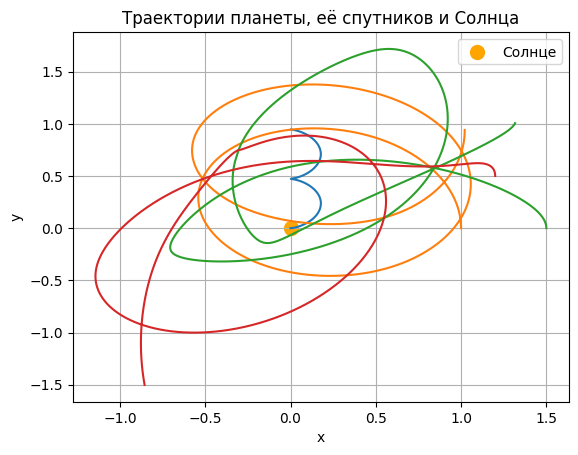

In [12]:
import numpy as np
import matplotlib.pyplot as plt


# Такой же, как до этого
def method(f, r0, v0, t_max, dt):
    t_list = np.arange(0, t_max, dt)
    r_list = np.zeros((len(t_list), len(r0)))
    v_list = np.zeros((len(t_list), len(v0)))

    r_list[0] = r0
    v_list[0] = v0

    r_list[1] = r_list[0] + v_list[0] * dt + 0.5 * f(r_list[0]) * dt**2

    for i in range(1, len(t_list) - 1):
        r_next = 2 * r_list[i] - r_list[i - 1] + f(r_list[i]) * dt**2
        r_list[i + 1] = r_next

    return t_list, r_list


def g_force(positions, masses):
    G = 1.0
    forces = np.zeros_like(positions)
    for i in range(len(masses)):
        for j in range(len(masses)):
            if i != j:
                r_vec = positions[i] - positions[j]
                r_norm = np.linalg.norm(r_vec)
                forces[i] -= G * masses[j] * r_vec / r_norm**3
    return forces


def simulate_orbits(r0, v0, masses, t_max, dt):
    t_list = np.arange(0, t_max, dt)
    r_list = np.zeros((len(t_list), len(masses), 2))
    r_list[0] = r0
    v_list = np.zeros_like(r_list)
    v_list[0] = v0

    r_list[1] = r_list[0] + v_list[0] * dt + 0.5 * g_force(r_list[0], masses) * dt**2

    for i in range(1, len(t_list) - 1):
        forces = g_force(r_list[i], masses)
        r_list[i + 1] = 2 * r_list[i] - r_list[i - 1] + forces * dt**2

    return t_list, r_list


def perpendiculate_satellite_velocity(r0, v0, masses):
    """Заимствованная функция для улучшения симуляции: меньше столкновений небесный тел"""
    for i in range(2, len(masses)):
        r_vec = r0[i] - r0[1]
        r_norm = np.linalg.norm(r_vec)
        v0[i] = np.array([0, np.sqrt(masses[1] / r_norm)])
    return v0


masses = np.array([1.0, 0.1, 0.01, 0.001])
r0 = np.array([[0.0, 0.0], [1.0, 0.0], [1.5, 0.0], [1.2, 0.5]])
v0 = np.array([[0.0, 0.0], [0.0, 1.0], [0.0, 0.8], [0.5, 1.2]])
v0 = perpendiculate_satellite_velocity(r0, v0, masses)

t_max = 10.0
dt = 0.01

t_list, r_list = simulate_orbits(r0, v0, masses, t_max, dt)

for i in range(len(masses)):
    plt.plot(r_list[:, i, 0], r_list[:, i, 1])
plt.scatter(0, 0, color="orange", s=100, label="Солнце")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Траектории планеты, её спутников и Солнца")
plt.legend()
plt.grid()
plt.show()